Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [32]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [33]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/MelanomaDetection/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/MelanomaDetection/Test')

In [36]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [37]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [38]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
          data_dir_train, 
          labels='inferred', 
          label_mode='int',
          class_names=None, 
          color_mode='rgb', 
          batch_size=batch_size, 
          image_size=(img_height,img_width), 
          shuffle=True, 
          seed=123, 
          validation_split=0.2, 
          subset="training",
          interpolation='bilinear',   
          follow_links=False,
          crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [39]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
          data_dir_train, 
          labels='inferred', 
          label_mode='int',
          class_names=None, 
          color_mode='rgb', 
          batch_size=batch_size, 
          image_size=(img_height,img_width), 
          shuffle=True, 
          seed=123, 
          validation_split=0.2, 
          subset="validation",
          interpolation='bilinear',   
          follow_links=False,
          crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [40]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

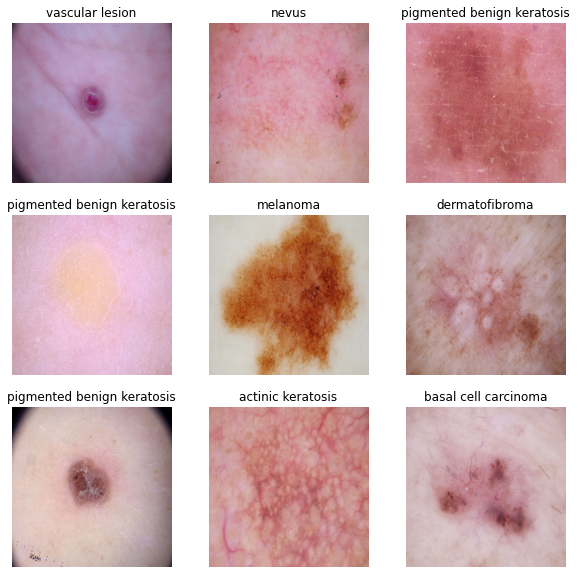

In [41]:
import matplotlib.pyplot as plt
### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")  

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [42]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [43]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(num_classes, activation = 'softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [44]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [45]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

### Train the model

In [46]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 15s 76ms/step - loss: 2.0003 - accuracy: 0.2589 - val_loss: 1.7304 - val_accuracy: 0.3579
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 1.7183 - accuracy: 0.3756 - val_loss: 1.5599 - val_accuracy: 0.4452
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5654 - accuracy: 0.4520 - val_loss: 1.4795 - val_accuracy: 0.5123
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5285 - accuracy: 0.4581 - val_loss: 1.4376 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4124 - accuracy: 0.5061 - val_loss: 1.4202 - val_accuracy: 0.5101
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3758 - accuracy: 0.5212 - val_loss: 1.3188 - val_accuracy: 0.5615
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3208 - accuracy: 0.5485 - val_loss: 1.3343 - val_accuracy: 0.5302
Epoch 8/20
5

### Visualizing training results

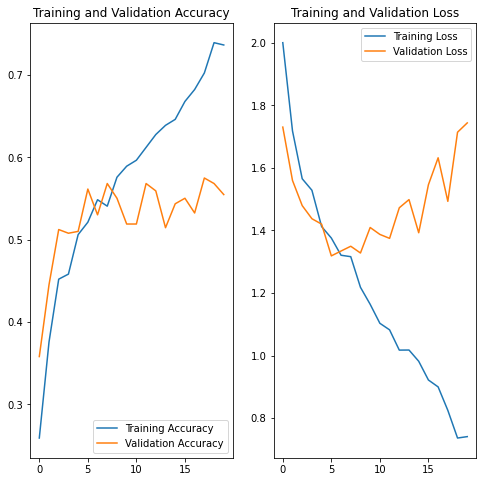

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

#### Inference from Model 1:

As we can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 55% accuracy on the validation set.

Overfitting: In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy is only around 55% in the training process. This difference is a clear indicator of overfitting


In [48]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

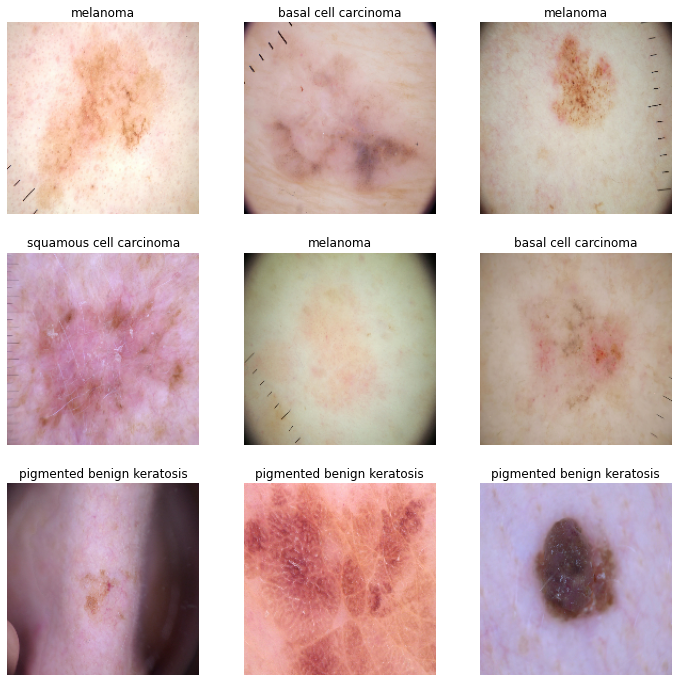

In [49]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [50]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
num_classes = 9
model = Sequential([
  data_augument,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(num_classes, activation = 'softmax')
])

### Compiling the model

In [51]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [52]:
## Your code goes here, note: train your model for 30 epochs
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 3s 30ms/step - loss: 2.0431 - accuracy: 0.2528 - val_loss: 1.8142 - val_accuracy: 0.3624
Epoch 2/30
56/56 [==============================] - 2s 27ms/step - loss: 1.7856 - accuracy: 0.3661 - val_loss: 1.6072 - val_accuracy: 0.4452
Epoch 3/30
56/56 [==============================] - 2s 27ms/step - loss: 1.6597 - accuracy: 0.4325 - val_loss: 1.5566 - val_accuracy: 0.4653
Epoch 4/30
56/56 [==============================] - 2s 27ms/step - loss: 1.5568 - accuracy: 0.4542 - val_loss: 1.5773 - val_accuracy: 0.4698
Epoch 5/30
56/56 [==============================] - 2s 27ms/step - loss: 1.4839 - accuracy: 0.4827 - val_loss: 1.5347 - val_accuracy: 0.4676
Epoch 6/30
56/56 [==============================] - 2s 27ms/step - loss: 1.4438 - accuracy: 0.5106 - val_loss: 1.4915 - val_accuracy: 0.5213
Epoch 7/30
56/56 [==============================] - 2s 27ms/step - loss: 1.4142 - accuracy: 0.5218 - val_loss: 1.4538 - val_accuracy: 0.5034
Epoch 8/30
56

### Visualizing the results

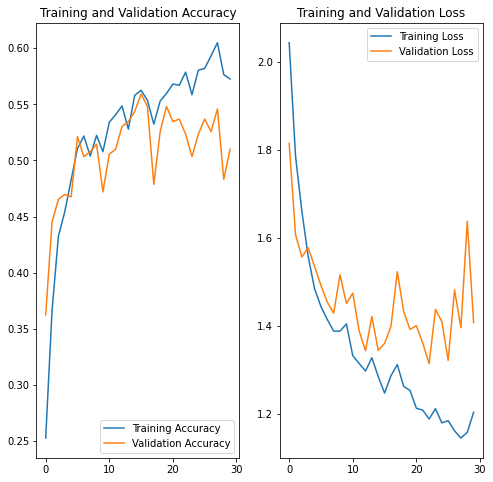

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Inference from Model 2 : 
After data augmentation and adding dropping layer,overfitting has been reduced significantly. On the other hand the training accuracy has also decreased by a great margin as compared to Model1.


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

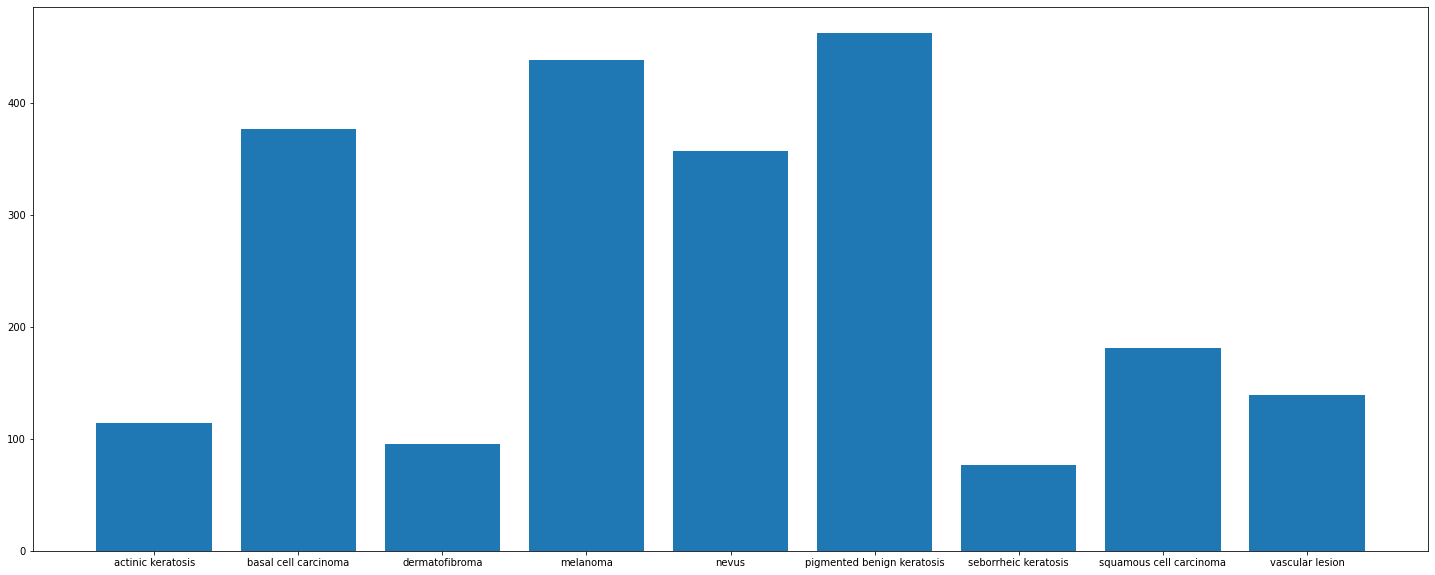

In [16]:
## Your code goes here.
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? 
 Ans) Seborrheic Keratosis
#### - Which classes dominate the data in terms proportionate number of samples? 
 Ans) Pigmented Benign Keratosis, Melanoma, Basal cell carcinoma and Nevus dominate the data.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [18]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [60]:
path_to_training_dataset="/content/drive/MyDrive/MelanomaDetection/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDetection/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6DC20F9150>: 100%|██████████| 500/500 [00:19<00:00, 26.16 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDetection/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6E5324A750>: 100%|██████████| 500/500 [00:18<00:00, 27.02 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDetection/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6DC2292FD0>: 100%|██████████| 500/500 [00:19<00:00, 26.02 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDetection/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=722x542 at 0x7F6DD607FAD0>: 100%|██████████| 500/500 [01:29<00:00,  5.57 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDetection/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7F6DC21EE510>: 100%|██████████| 500/500 [01:10<00:00,  7.13 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDetection/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6DC22563D0>: 100%|██████████| 500/500 [00:18<00:00, 27.71 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDetection/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6E532E2DD0>: 100%|██████████| 500/500 [00:41<00:00, 12.02 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDetection/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6DBF3C1490>: 100%|██████████| 500/500 [00:18<00:00, 27.54 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDetection/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6DC2322B10>: 100%|██████████| 500/500 [00:18<00:00, 26.40 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of images after augmentation along with original images.

In [71]:
image_count_train = len(list(data_dir_train.glob('**/*.jpg')))
print(image_count_train)

6739


### Lets see the distribution of augmented data after adding new images to the original training data.

In [72]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/MelanomaDetection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031381.jpg_251d78c8-4445-4694-baa1-12e96a421099.jpg',
 '/content/drive/MyDrive/MelanomaDetection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028190.jpg_95f1571e-d759-402b-a598-b2cbdc4683cd.jpg',
 '/content/drive/MyDrive/MelanomaDetection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029210.jpg_b8187280-5e9f-49c1-9a4e-ff04c4c35710.jpg',
 '/content/drive/MyDrive/MelanomaDetection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028314.jpg_bbfa589b-71a1-46f2-82ba-91bdadf773a7.jpg',
 '/content/drive/MyDrive/MelanomaDetection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032206.jpg_9a3ffe93-7879-4268-9143-dc7f32c7a8b5.jpg',
 '/content/drive/MyDrive/MelanomaDetection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027958.jpg_b06ae9ea-a698-4565-9a94-17f248a1ba8a.jpg',
 '/content/drive/MyDrive/MelanomaD

In [73]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [74]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [75]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesson_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesson_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [76]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [78]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [79]:
data_dir_train= os.path.join(data_dir_train)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [80]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [81]:
## your code goes here
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.14493418 0.85817


In [84]:
num_classes = 9
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [85]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [86]:
epochs= 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 30s 170ms/step - loss: 1.8066 - accuracy: 0.3093 - val_loss: 1.5584 - val_accuracy: 0.4202
Epoch 2/30
169/169 [==============================] - 29s 169ms/step - loss: 1.3830 - accuracy: 0.4776 - val_loss: 1.3136 - val_accuracy: 0.5071
Epoch 3/30
169/169 [==============================] - 29s 168ms/step - loss: 1.1713 - accuracy: 0.5647 - val_loss: 1.1281 - val_accuracy: 0.5746
Epoch 4/30
169/169 [==============================] - 29s 168ms/step - loss: 0.9706 - accuracy: 0.6422 - val_loss: 1.3261 - val_accuracy: 0.5538
Epoch 5/30
169/169 [==============================] - 30s 170ms/step - loss: 0.8392 - accuracy: 0.6997 - val_loss: 1.1557 - val_accuracy: 0.6355
Epoch 6/30
169/169 [==============================] - 30s 171ms/step - loss: 0.6730 - accuracy: 0.7619 - val_loss: 0.8424 - val_accuracy: 0.7268
Epoch 7/30
169/169 [==============================] - 30s 170ms/step - loss: 0.5801 - accuracy: 0.7947 - val_loss: 0.8492 - val_accuracy: 0.7

#### **Todo:**  Visualize the model results

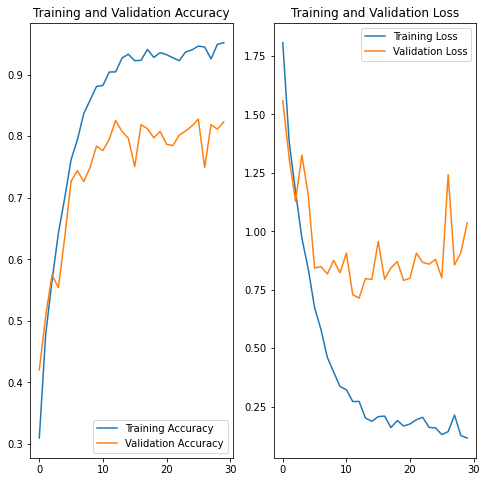

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



#### Inference from Model 3 : 
Model 3 has achieved a training accurafcy of 95% and validation accuracy close to 80%. The problem of Underfitting is avoided. However the validation accuracy could be better if there are more number of sample images.

The class rebalance has helped to achieve these results, However sampling up of 1000 images in each class may result in better accuracy.